In [1]:
import pandas as pd
import numpy as np
from numpy.random import seed
import random
import warnings
warnings.filterwarnings('ignore')
seed(2020) #set random seed

### Load the processed data, note that we've already converted the dcd/pdb file to csv file. 

In [2]:
df_pca=pd.read_csv('./Ala13/PCAanalysis.csv',names=['PCA1','PCA2'])
df_cor=pd.read_csv('./Ala13/Atoms_coordinates_whole.csv',header=None)

In [3]:
df_pca.head()

,PCA1,PCA2
0,0.0162,0.002330
1,0.0164,0.000557
2,0.0168,-0.000337
3,0.0175,-0.001910
4,0.0177,-0.001320


In [4]:
df_cor.head()

,0,1,2,3,4,5,6,7,8,9,...,188,189,190,191,192,193,194,195,196,197
0,30.130003,30.730001,33.320004,28.780001,30.370003,32.850002,27.740002,31.210001,33.570000,28.580000,...,18.540001,20.970001,20.630001,18.210001,21.800001,19.700001,18.200001,19.960001,20.500002,17.490002
1,30.582726,31.034544,33.609142,29.322193,30.378710,33.246048,28.169268,31.027327,34.018612,29.069057,...,18.046659,21.080175,19.482227,17.698109,21.676388,18.441927,18.062536,20.435606,19.408522,16.636789
2,27.547211,30.999948,33.498272,28.881954,30.967804,32.882378,29.850468,30.103348,33.687733,28.909615,...,17.698475,21.072111,20.966135,17.106026,21.194897,19.720905,17.171005,20.400530,21.533232,16.229221
3,27.889790,30.885441,33.714222,29.036554,30.401567,32.932556,29.474493,29.073942,33.540764,28.938217,...,18.102945,22.408243,19.916569,17.357298,23.642900,19.738064,17.475031,21.699007,19.404203,16.474821
4,27.751440,29.981630,33.914619,28.425182,30.937717,33.022114,29.750643,31.394354,33.635334,28.520418,...,18.586025,21.225840,20.214525,17.992739,22.343639,20.065355,17.446964,20.361906,19.368549,17.718796


### Concatenate the PCA values and its corresponding trajectories,here we regard PC1/PC2 values as labels in machine learning tasks.

In [5]:
train_data=np.concatenate((df_pca,df_cor),axis=1)
train_data.shape, df_pca.shape, df_cor.shape
train_data[:2]

array([[1.62000000e-02, 2.33000000e-03, 3.01300030e+01, 3.07300014e+01,
        3.33200035e+01, 2.87800007e+01, 3.03700028e+01, 3.28500023e+01,
        2.77400017e+01, 3.12100010e+01, 3.35699997e+01, 2.85799999e+01,
        3.03899994e+01, 3.13400002e+01, 2.79200001e+01, 2.94400024e+01,
        3.09200020e+01, 2.90000000e+01, 3.14500027e+01, 3.06500015e+01,
        2.90800018e+01, 3.16399994e+01, 2.92200012e+01, 3.00400009e+01,
        3.27800026e+01, 2.88800030e+01, 2.94800014e+01, 3.03199997e+01,
        2.85600014e+01, 2.88500023e+01, 2.98400021e+01, 2.76200008e+01,
        3.04900017e+01, 2.96400032e+01, 2.91000004e+01, 3.10700016e+01,
        2.84600029e+01, 2.84799995e+01, 3.25200005e+01, 2.82200012e+01,
        2.89000015e+01, 3.02100010e+01, 2.72100029e+01, 2.86100006e+01,
        2.99600010e+01, 2.65200024e+01, 2.76300030e+01, 2.97900009e+01,
        2.69100017e+01, 2.98400021e+01, 2.89300003e+01, 2.58100014e+01,
        3.02300034e+01, 2.88900013e+01, 2.57200012e+01, 3.175000

In [6]:
np.random.shuffle(train_data)
train_dataset=train_data[:2000]
test_dataset=train_data[2000:]

In [7]:
train_dataset_pd=pd.DataFrame(train_dataset)
#train_dataset_pd
test_dataset_pd=pd.DataFrame(test_dataset)
#train_dataset_pd.to_csv('train_data.csv',header=None,index=None)
#test_dataset_pd.to_csv('test_data_500.csv',header=None,index=None)

In [8]:
X_test=test_dataset[:,:2]
Y_test=test_dataset[:,2:]
X_train=train_dataset[:,:2]
Y_train=train_dataset[:,2:]
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((2000, 2), (2000, 198), (500, 2), (500, 198))

### Data Normalisation

In [9]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler
# note that we must define two minmaxscalers
scalar1 = MinMaxScaler()
scalar2 = MinMaxScaler()

In [10]:
X_scaled_train=scalar1.fit_transform(X_train)
Y_scaled_train=scalar2.fit_transform(Y_train)
X_scaled_test=scalar1.transform(X_test)
Y_scaled_test=scalar2.transform(Y_test)

### Build the neural network model

In [11]:
from keras.models import Sequential
from keras.layers import Input,Dense, Activation
from keras.layers import Dropout
from keras import regularizers
from keras.losses import mean_squared_error, binary_crossentropy
from keras import objectives
from keras.models import Model
from keras.utils import plot_model
from keras import optimizers

Using TensorFlow backend.


In [12]:
latent_dim = 2
intermediate_dim_1=16
intermediate_dim_2=32
intermediate_dim_3=64
original_dim=198
#Encoder part
input_net=Input(shape=(original_dim,), name="embeding")
encoded_h_3 = Dense(intermediate_dim_3, activation='relu', name="hiddenLayer1",kernel_initializer='normal')(input_net)
encoded_h_2 = Dense(intermediate_dim_2, activation='relu', name="hiddenLayer2",kernel_initializer='normal')(encoded_h_3)
encoded_h_1 = Dense(intermediate_dim_1, activation='relu', name="hiddenLayer3",kernel_initializer='normal')(encoded_h_2)
PCA=Dense(latent_dim, activation='sigmoid', name="encode_out",kernel_initializer='normal')(encoded_h_1)

#PCA=Dense(latent_dim, activation='relu', name="encode_out")(input_net)
#Decoder part
decoded_h_1= Dense(intermediate_dim_1,kernel_initializer='normal', activation='relu', name="hiddenLayer4")(PCA)
decoded_h_2= Dense(intermediate_dim_2,kernel_initializer='normal', activation='relu', name="hiddenLayer5")(decoded_h_1)
decoded_h_3= Dense(intermediate_dim_3,kernel_initializer='normal', activation='relu', name="hiddenLayer6")(decoded_h_2)
decoded = Dense(original_dim,kernel_initializer='normal', activation='sigmoid', name="decode_out")(decoded_h_3)
#decoded = Dense(original_dim, activation='sigmoid', name="decode_out")(PCA)
# end-to-end autoencoder
autoencoder = Model(inputs=input_net, outputs=[PCA, decoded], name="AutoEncoder")

### Define the loss function, we use the mse loss function in two different part in modified AE 

In [13]:
def latent_loss(y_true, y_pred):
    return mean_squared_error(y_true,y_pred)

# loss compile
adam=optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.99, epsilon=1e-08)
autoencoder.compile(optimizer=adam,
              loss={'encode_out': latent_loss,'decode_out': latent_loss},
              loss_weights={'encode_out':1, 'decode_out': 1},
              metrics=["mean_squared_error"])

### Show the structure of autoencoder model

In [14]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embeding (InputLayer)        (None, 198)               0         
_________________________________________________________________
hiddenLayer1 (Dense)         (None, 64)                12736     
_________________________________________________________________
hiddenLayer2 (Dense)         (None, 32)                2080      
_________________________________________________________________
hiddenLayer3 (Dense)         (None, 16)                528       
_________________________________________________________________
encode_out (Dense)           (None, 2)                 34        
_________________________________________________________________
hiddenLayer4 (Dense)         (None, 16)                48        
_________________________________________________________________
hiddenLayer5 (Dense)         (None, 32)                544       
__________

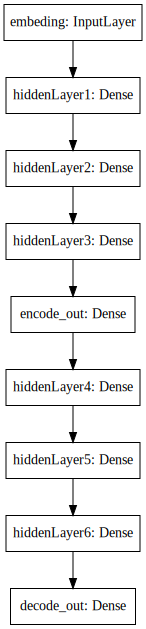

In [15]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
plot_model(autoencoder, to_file='ModifiedAE.png')
SVG(model_to_dot(autoencoder).create(prog='dot', format='svg'))

In [16]:
history=autoencoder.fit(Y_scaled_train,[X_scaled_train, Y_scaled_train],
                shuffle=True,
                epochs=100,
                batch_size=8,
                validation_data=(Y_scaled_test,[X_scaled_test,Y_scaled_test]))

Train on 2000 samples, validate on 500 samples
Epoch 1/100
2000/2000 [==============================] - 3s 1ms/step - loss: 0.0513 - encode_out_loss: 0.0277 - decode_out_loss: 0.0237 - encode_out_mean_squared_error: 0.0277 - decode_out_mean_squared_error: 0.0237 - val_loss: 0.0276 - val_encode_out_loss: 0.0055 - val_decode_out_loss: 0.0221 - val_encode_out_mean_squared_error: 0.0055 - val_decode_out_mean_squared_error: 0.0221
Epoch 2/100
2000/2000 [==============================] - 1s 274us/step - loss: 0.0238 - encode_out_loss: 0.0037 - decode_out_loss: 0.0201 - encode_out_mean_squared_error: 0.0037 - decode_out_mean_squared_error: 0.0201 - val_loss: 0.0228 - val_encode_out_loss: 0.0026 - val_decode_out_loss: 0.0201 - val_encode_out_mean_squared_error: 0.0026 - val_decode_out_mean_squared_error: 0.0201
Epoch 3/100
2000/2000 [==============================] - 1s 285us/step - loss: 0.0201 - encode_out_loss: 0.0020 - decode_out_loss: 0.0181 - encode_out_mean_squared_error: 0.0020 - decod

2000/2000 [==============================] - 1s 260us/step - loss: 0.0082 - encode_out_loss: 5.6981e-04 - decode_out_loss: 0.0077 - encode_out_mean_squared_error: 5.6981e-04 - decode_out_mean_squared_error: 0.0077 - val_loss: 0.0081 - val_encode_out_loss: 6.8918e-04 - val_decode_out_loss: 0.0074 - val_encode_out_mean_squared_error: 6.8918e-04 - val_decode_out_mean_squared_error: 0.0074
Epoch 22/100
2000/2000 [==============================] - 1s 279us/step - loss: 0.0082 - encode_out_loss: 5.8449e-04 - decode_out_loss: 0.0076 - encode_out_mean_squared_error: 5.8449e-04 - decode_out_mean_squared_error: 0.0076 - val_loss: 0.0081 - val_encode_out_loss: 6.4369e-04 - val_decode_out_loss: 0.0075 - val_encode_out_mean_squared_error: 6.4369e-04 - val_decode_out_mean_squared_error: 0.0075
Epoch 23/100
2000/2000 [==============================] - 1s 256us/step - loss: 0.0081 - encode_out_loss: 5.4301e-04 - decode_out_loss: 0.0076 - encode_out_mean_squared_error: 5.4301e-04 - decode_out_mean_squa

2000/2000 [==============================] - 1s 386us/step - loss: 0.0072 - encode_out_loss: 5.6638e-04 - decode_out_loss: 0.0067 - encode_out_mean_squared_error: 5.6638e-04 - decode_out_mean_squared_error: 0.0067 - val_loss: 0.0072 - val_encode_out_loss: 6.4385e-04 - val_decode_out_loss: 0.0065 - val_encode_out_mean_squared_error: 6.4385e-04 - val_decode_out_mean_squared_error: 0.0065
Epoch 42/100
2000/2000 [==============================] - 1s 289us/step - loss: 0.0072 - encode_out_loss: 5.8149e-04 - decode_out_loss: 0.0066 - encode_out_mean_squared_error: 5.8149e-04 - decode_out_mean_squared_error: 0.0066 - val_loss: 0.0072 - val_encode_out_loss: 7.3763e-04 - val_decode_out_loss: 0.0064 - val_encode_out_mean_squared_error: 7.3763e-04 - val_decode_out_mean_squared_error: 0.0064
Epoch 43/100
2000/2000 [==============================] - 1s 285us/step - loss: 0.0071 - encode_out_loss: 5.9073e-04 - decode_out_loss: 0.0065 - encode_out_mean_squared_error: 5.9073e-04 - decode_out_mean_squa

2000/2000 [==============================] - 1s 277us/step - loss: 0.0064 - encode_out_loss: 7.0227e-04 - decode_out_loss: 0.0057 - encode_out_mean_squared_error: 7.0227e-04 - decode_out_mean_squared_error: 0.0057 - val_loss: 0.0062 - val_encode_out_loss: 6.7142e-04 - val_decode_out_loss: 0.0055 - val_encode_out_mean_squared_error: 6.7142e-04 - val_decode_out_mean_squared_error: 0.0055
Epoch 62/100
2000/2000 [==============================] - 0s 247us/step - loss: 0.0064 - encode_out_loss: 7.4402e-04 - decode_out_loss: 0.0057 - encode_out_mean_squared_error: 7.4402e-04 - decode_out_mean_squared_error: 0.0057 - val_loss: 0.0062 - val_encode_out_loss: 6.1628e-04 - val_decode_out_loss: 0.0055 - val_encode_out_mean_squared_error: 6.1628e-04 - val_decode_out_mean_squared_error: 0.0055
Epoch 63/100
2000/2000 [==============================] - 1s 272us/step - loss: 0.0063 - encode_out_loss: 7.1962e-04 - decode_out_loss: 0.0056 - encode_out_mean_squared_error: 7.1962e-04 - decode_out_mean_squa

2000/2000 [==============================] - 1s 279us/step - loss: 0.0060 - encode_out_loss: 6.3026e-04 - decode_out_loss: 0.0053 - encode_out_mean_squared_error: 6.3026e-04 - decode_out_mean_squared_error: 0.0053 - val_loss: 0.0057 - val_encode_out_loss: 5.3165e-04 - val_decode_out_loss: 0.0052 - val_encode_out_mean_squared_error: 5.3165e-04 - val_decode_out_mean_squared_error: 0.0052
Epoch 82/100
2000/2000 [==============================] - 1s 327us/step - loss: 0.0060 - encode_out_loss: 6.5630e-04 - decode_out_loss: 0.0054 - encode_out_mean_squared_error: 6.5630e-04 - decode_out_mean_squared_error: 0.0054 - val_loss: 0.0058 - val_encode_out_loss: 5.8946e-04 - val_decode_out_loss: 0.0052 - val_encode_out_mean_squared_error: 5.8946e-04 - val_decode_out_mean_squared_error: 0.0052
Epoch 83/100
2000/2000 [==============================] - 1s 368us/step - loss: 0.0059 - encode_out_loss: 6.0533e-04 - decode_out_loss: 0.0053 - encode_out_mean_squared_error: 6.0533e-04 - decode_out_mean_squa

In [17]:
autoencoder.save('autoencoder_model.h5')
del autoencoder

### Load the previous model and utilise the decoder part to predict the given testing data

In [18]:
# generator, from latent space to reconstructed inputs
decoder_input = Input(shape=(latent_dim,))
#decoded_h = Dense(intermediate_dim, activation="relu", name="hiddenLayer2")(decoder_input)
#decoded = Dense(original_dim, activation='relu', name="decode_out")(decoded_h)

decoded_h_1= Dense(intermediate_dim_1,kernel_initializer='normal', activation='relu', name="hiddenLayer4")(decoder_input)
decoded_h_2= Dense(intermediate_dim_2,kernel_initializer='normal', activation='relu', name="hiddenLayer5")(decoded_h_1)
decoded_h_3= Dense(intermediate_dim_3,kernel_initializer='normal', activation='relu', name="hiddenLayer6")(decoded_h_2)
decoded = Dense(original_dim,kernel_initializer='normal', activation='sigmoid', name="decode_out")(decoded_h_3)

generator = Model(decoder_input, decoded)
# load weights from first model by name
generator.load_weights('autoencoder_model.h5', by_name=True)

### Plot the training and testing loss

In [19]:
import matplotlib.pyplot as plt

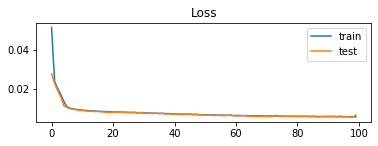

In [20]:
plt.subplot(211)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

In [21]:
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
hiddenLayer4 (Dense)         (None, 16)                48        
_________________________________________________________________
hiddenLayer5 (Dense)         (None, 32)                544       
_________________________________________________________________
hiddenLayer6 (Dense)         (None, 64)                2112      
_________________________________________________________________
decode_out (Dense)           (None, 198)               12870     
Total params: 15,574
Trainable params: 15,574
Non-trainable params: 0
_________________________________________________________________


In [22]:
X_scaled_test.shape, Y_scaled_test.shape

((500, 2), (500, 198))

### Load the 7 testing structures 

In [23]:
predict_dataset=pd.read_csv('./Ala13/new_testing_data_7.csv',names=['PCA1','PCA2'])
predict_dataset.dropna(axis=0, how='any', inplace=True)

In [24]:
predict_dataset=scalar1.transform(predict_dataset)

### Predict the 7 testing structures

In [25]:
pred=generator.predict(predict_dataset, batch_size=16)
print(pred)
save=pd.DataFrame(pred)

[[0.23769924 0.632008   0.2142971  ... 0.8410016  0.8391993  0.45276335]
 [0.28619933 0.7484152  0.3297595  ... 0.20682988 0.2697998  0.55449843]
 [0.24031763 0.76813376 0.42356506 ... 0.25058746 0.5184897  0.34048927]
 ...
 [0.29478195 0.321959   0.88936955 ... 0.12394996 0.33340165 0.5180512 ]
 [0.26606458 0.30640936 0.88634723 ... 0.3097649  0.46840134 0.2937768 ]
 [0.24825594 0.2651625  0.8775919  ... 0.31508204 0.30160454 0.8411553 ]]


In [26]:
y_pred=scalar2.inverse_transform(save)

In [27]:
y_pred

array([[27.57689083, 32.89801655, 26.45265239, ..., 31.92043376,
        26.82715436, 20.65283806],
       [28.07402518, 33.788053  , 27.73889473, ..., 18.27385331,
        16.38266442, 22.65714283],
       [27.60372976, 33.93881917, 28.78388137, ..., 19.21546178,
        20.94438135, 18.44090228],
       ...,
       [28.16199854, 30.52741543, 33.97290754, ..., 16.49038134,
        17.5493126 , 21.93908818],
       [27.86764053, 30.40852465, 33.9392392 , ..., 20.48888591,
        20.02561073, 17.52061011],
       [27.68509882, 30.09315564, 33.84170554, ..., 20.60330435,
        16.96605848, 28.30463113]])

In [28]:
y_pred=pd.DataFrame(y_pred)

In [29]:
y_pred

,0,1,2,3,4,5,6,7,8,9,...,188,189,190,191,192,193,194,195,196,197
0,27.576891,32.898017,26.452652,27.498199,32.100820,27.450159,26.369065,31.389365,27.326371,28.628122,...,19.770326,31.626568,26.319072,20.476518,31.765425,26.319023,20.266507,31.920434,26.827154,20.652838
1,28.074025,33.788053,27.738895,27.828004,32.847460,28.623116,26.925536,32.057180,28.138802,29.039290,...,22.327568,18.454746,16.357615,22.562991,18.426316,16.259373,22.716376,18.273853,16.382664,22.657143
2,27.603730,33.938819,28.783881,27.444845,32.932098,29.341796,26.711798,32.257410,28.644018,28.639234,...,19.098040,19.304901,21.181751,18.713751,19.121224,21.040019,18.440740,19.215462,20.944381,18.440902
3,27.953681,30.438137,33.947702,28.928762,30.684510,33.275026,29.889331,30.097888,33.897522,28.843112,...,19.009457,19.140041,19.552353,18.888543,19.027230,19.297281,18.644801,19.062834,19.275901,18.680212
4,28.161999,30.527415,33.972908,29.115865,30.775361,33.350912,30.027998,30.183057,33.960308,29.048795,...,22.212005,16.767869,17.634442,22.127745,16.453635,17.376274,22.207597,16.490381,17.549313,21.939088
5,27.867641,30.408525,33.939239,28.845721,30.649058,33.243824,29.820058,30.066244,33.872018,28.760363,...,17.896152,20.483544,20.389887,17.759949,20.412395,20.134910,17.425805,20.488886,20.025611,17.520610
6,27.685099,30.093156,33.841706,28.591374,30.143463,33.353859,29.165158,29.441455,34.049763,28.735232,...,27.790651,20.781904,17.301810,28.155882,20.636580,17.147866,28.587948,20.603304,16.966058,28.304631


### Save the results for predicting

In [30]:
y_pred.to_csv('new_results_7.csv',index=False,header=False)